In [1]:
import igraph as ig
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_mutual_info_score as AMI
import partition_igraph
from matplotlib import pyplot as plt
from collections import Counter
import random
import pickle
import os
import seaborn as sns
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve
from scipy.sparse import csr_matrix
import scipy.sparse as sparse 
import time
from statistics import mode
from abcd_graph import ABCDGraph, ABCDParams
import csv
import subprocess
import sys
sys.path.append('../')
from CAS import *
from itertools import combinations
import powerlaw
from itertools import combinations
from collections import defaultdict


In [2]:
## DEV
path = '/data/ABCDoo/'
oNMI = '/work/home/fcthebe/Tools/oNMI/onmi' 

## MAC
#path = '../Datasets/ABCDoo/' 
#oNMI = '/Users/francois/Book/GraphMiningNotebooks/oNMI/onmi' 
#LFR = '/Users/francois/Tools/LFRo/binary_networks/benchmark'


In [3]:
## this assumes community 0 are outliers and 'gt' exists in graph G
## M: membership matrix
## S: score matrix (C or Beta)
def outliers_AUC(G, M, S):
    y = [int(x>0) for x in G.vs['gt']]
    x = np.array(S.max(axis=1).todense()).flatten()
    ctr = Counter(np.array(M.sum(axis=1)).flatten())
    print('With matrix M:\noutliers:',ctr[0])
    print('correct outliers:',sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(G.vs['gt']) == 0)))
    print('\nWith scores:\noutlier AUC:',AUC(y,x)) 
        
## Read ABCD+oo graph
def readGraph(xi=0.5, eta=1.5, rep=1, dim=0):
    ## if dim>0
    if dim>0:
        fn = path+'networkfile'+str(xi)+'_'+str(eta)+'_'+str(rep)+'_'+str(dim)+'.txt'
    ## read edges, build graph
    else:
        fn = path+'networkfile'+str(xi)+'_'+str(eta)+'_'+str(rep)+'.txt'
    Edges = pd.read_csv(fn, sep='\t', header=None)-1
    G = ig.Graph.DataFrame(Edges, directed=False)
    ## read communities
    if dim>0:
        fn = path+'communityfile'+str(xi)+'_'+str(eta)+'_'+str(rep)+'_'+str(dim)+'.txt'
    else:
        fn = path+'communityfile'+str(xi)+'_'+str(eta)+'_'+str(rep)+'.txt'
    L = []
    with open(fn, "r") as infile:
        for line in infile:
            x = line.split('\t')
            L.append([int(y)-1 for y in x[1].rstrip()[1:-1].split(',')]) ## map to 0-based
    G.vs['comms'] = L
    G.vs['n_comms'] = [len(x) for x in G.vs['comms']]
    return G
   
## calls the oNMI executable, format of inputs: list of lists (communities)
def compute_oNMI(First, Second):
    fn1 = '__'+str(random.random())[2:]
    with open(fn1,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(First)
    f.close()   

    fn2 = '__'+str(random.random())[2:]
    with open(fn2,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(Second)
    f.close()   
    x = float(subprocess.check_output([oNMI,fn1,fn2]).decode("utf-8").split()[1])
    _ = os.system('rm '+fn1)
    _ = os.system('rm '+fn2)
    return x

## ???
def memberships2list(S):
    L = []
    for i in range(len(S.indptr)-1):
        if S.indptr[i] == S.indptr[i+1]:
            L.append([0]) ## no membership == outlier (community 0)
        else:
            L.append(list(S.indices[S.indptr[i]:S.indptr[i+1]]+1)) ## 1-based
    return L

## given a list of node memberships, return list of communities
def mems2comms(X):
    nc = max(set([i for j in X for i in j]))+1  
    n = len(X)
    L = [[] for _ in range(nc)]
    for i in range(n):
        for j in X[i]:
            L[j].append(i)
    return L

def CPM(g, k=3):
    cls = list(map(set, g.cliques(min=k,max=k)))
    edgelist = []
    for i in range(len(cls)):
        edgelist.append((i,i))
    for i,j in combinations(range(len(cls)),2):
        if len(cls[i].intersection(cls[j])) >= (k-1):
            edgelist.append((i,j))
    cg = ig.Graph(edgelist, directed=False)
    clusters = cg.connected_components()
    L = []
    for cluster in clusters:
        members = set()
        for i in cluster:
            members.update(cls[i])
        L.append(set(g.vs[members]["name"]))
    return L


def EgoSplit(G, split='CC', algo='LP'):
    g = G.copy()
    ## implement ego-split approach with LP+LP and LP+ECG
    g.vs['original'] = g.vs['name']
    ## use the vertex names to avoid issues when vertices are re-mapped ...
    names = g.vs['name']
    ## step 1 - ego-net splits
    for nm in names:
        v = g.vs.find(nm).index
        n = g.neighbors(v)
        sg = g.subgraph(n)
        if split == 'LP':
            x = sg.community_label_propagation().membership
        else:
            x = sg.connected_components().membership
        if np.min(x)==-1:
            x = [i+1 for i in x]
        for j in set(x):
            g.add_vertex(name=nm+'.'+str(j),original=nm)

        l = sg.vs['name']
        for j in range(len(x)):
            g.add_edge(nm+'.'+str(x[j]) , l[j])
        g.delete_vertices(v)
    ## step 2 -- cluster w.r.t. multiple personae
    if algo=='LP':
        cl = g.community_label_propagation()
    else:
        cl = g.community_ecg(ens_size=32, final='leiden') ## Leiden
    C = [set(sg.vs['original']) for sg in cl.subgraphs()]
    return C


## ABCD-oo graphs

Main 2 files:

```
networkfile<xi>_<eta>_<rep>.txt : the edges, 1-based node ids, tab separated
communityfile<xi>_<eta>_<rep>.txt : node <tab> list of communities in [], for example:
1       [24]
2       [3, 28]
3       [10]
```

All files for one case:

```
communityfile0.5_1.5_10.txt
communitysizesfile0.5_1.5_10.txt
degreefile0.5_1.5_10.txt
networkfile0.5_1.5_10.txt
```

All graph have 250 outlier nodes, mapped to community 0 below

We also have graphs using different dimension (1 to 4) for xi=0.25, eta=1.5, rep=1.


# EDA - compare ABCD-oo and LFRo

We compare the following for an ABCD-oo and "similar" LFRo graphs:
* degree and community size distributions
* degree distribution for outliers vs non-outliers (ABCD-oo only)
* number of memberships per node
* correlation between degree and number of memberships
* size of overlaps between 2, 3 or 4 communities (number of nodes)
* density of 'large' overlaps (2 communities, 25+ nodes)

By "similar" LFRo, we mean:
* same number of nodes
* same mean and max degree
* same power law exponents
* same min and max community sizes
* for mu, we use equation (2) from our first ABCD paper to set it given xi
* for the overlap, we set om = 4 (by default), number of communities and set on (number of nodes) to match eta


In [4]:
XI = 0.6
ETA = 2.5
LARGE = 25 ## for the overlap densities

## read ABCD-oo graph
G = readGraph(xi=XI, eta=ETA, rep=1)

In [5]:
## degree distribution
deg = G.degree()
print('min degree',min(deg),'max degree',max(deg))
X = powerlaw.Fit(deg, xmin = min(deg), verbose=False)
print("Value of gamma:", X.power_law.alpha)
print("l':", X.power_law.xmin)
print("KS statistic:", X.power_law.D)


min degree 10 max degree 100
Value of gamma: 2.847697469441714
l': 10.0
KS statistic: 0.04178787922819427


In [6]:
## community size distribution
C = [len(y) for y in mems2comms([x for x in G.vs['comms']])]
print('min comm',min(C),'max comm',max(C))
X = powerlaw.Fit(C, xmin=min(C), verbose=False)
print("Value of gamma:", X.power_law.alpha)
print("l':", X.power_law.xmin)
print("KS statistic:", X.power_law.D)


min comm 50 max comm 1060
Value of gamma: 1.770009958872631
l': 50.0
KS statistic: 0.15838296467676544


In [7]:
## number of memberships
Counter(G.vs['n_comms'])

Counter({2: 3787, 3: 3109, 1: 1622, 4: 1309, 5: 169, 6: 4})

In [8]:
## degree vs number of communities - correlation
np.corrcoef(G.degree(),G.vs['n_comms'])[0,1]

0.014026088875486073

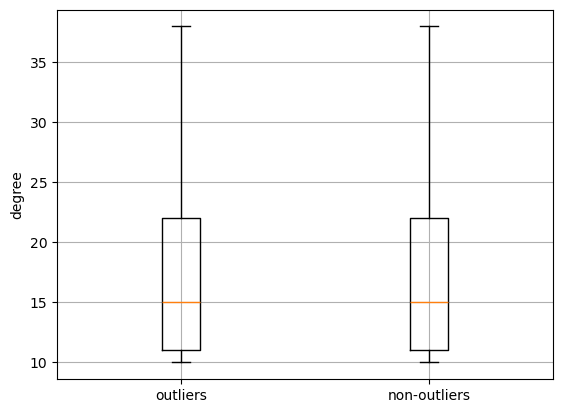

In [9]:
## degree: outliers vs other nodes (no difference expected)
deg_o = [G.degree(v) for v in G.vs if v['comms'][0]==0]
deg_no = [G.degree(v) for v in G.vs if v['comms'][0]!=0]
plt.boxplot([deg_o, deg_no], showfliers=False, labels=['outliers','non-outliers'])
plt.ylabel('degree')
plt.grid();


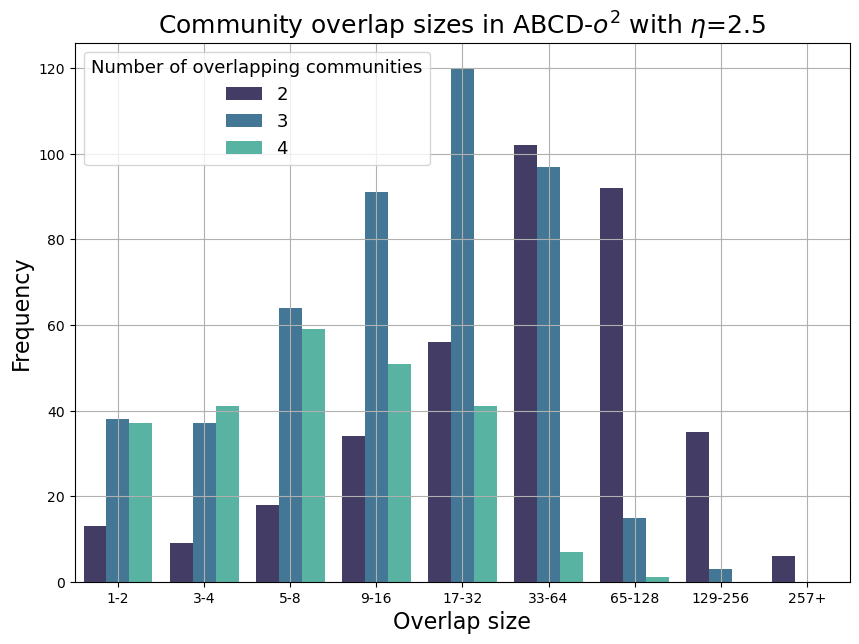

In [10]:
## Overlap sizes
C = [set(x) for x in G.vs['comms'] if x[0]!=0]
two_overlaps = defaultdict(int)
three_overlaps = defaultdict(int)
four_overlaps = defaultdict(int)
for com in C:
    for k2 in combinations(com, 2):
        two_overlaps[frozenset(k2)] += 1
    for k3 in combinations(com, 3):
        three_overlaps[frozenset(k3)] += 1
    for k4 in combinations(com, 4):
        four_overlaps[frozenset(k4)] += 1

## bin the results
_df = pd.DataFrame()
bins = [1,2,4,8,16,32,64,128,256,9999]
bin_labels = [str(bins[i]+1)+"-"+str(bins[i+1]) for i in range(len(bins)-1)]
bin_labels[0] = "1-2"
bin_labels[8] = '257+'
_df['bin'] = np.tile(bin_labels, 3)
_df['communities'] = np.repeat([2,3,4],9)
_df['count'] = np.concatenate([np.histogram(list(two_overlaps.values()), bins=bins)[0],np.histogram(list(three_overlaps.values()), bins=bins)[0],np.histogram(list(four_overlaps.values()), bins=bins)[0]])

plt.figure(figsize=(10,7))
sns.barplot(x="bin", y="count", hue="communities", data=_df, palette=sns.color_palette('mako', n_colors=3));
plt.xlabel('Overlap size', fontsize=16);
plt.ylabel('Frequency', fontsize=16)
plt.grid()
plt.legend(title='Number of overlapping communities', fontsize=13, title_fontsize=13)
plt.title(r'Community overlap sizes in ABCD-$o^2$ with $\eta$='+str(ETA), fontsize=18);


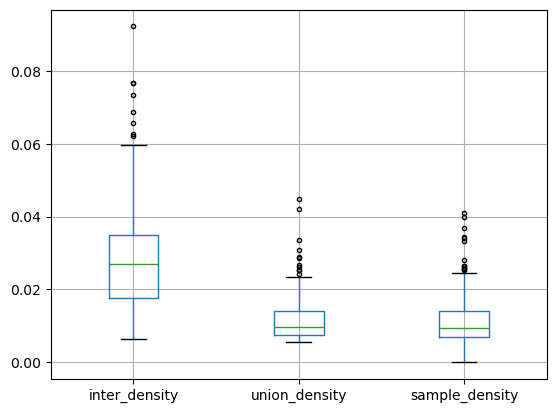

In [11]:
## density in large overlaps 

## ignore outliers
C = [set(x) for x in G.vs['comms']]
Communities = mems2comms(C)[1:]
nc = len(Communities)

L = []
for i in range(nc-1):
    for j in range(i+1,nc):
        I = set(Communities[i]).intersection(set(Communities[j]))
        if len(I)>=LARGE:
            sg = G.subgraph(I)
            idt = 2*sg.ecount()/(sg.vcount()*(sg.vcount()-1))
            inter = sg.vcount()
            sg = G.subgraph(set(Communities[i]).union(set(Communities[j])))
            udt = 2*sg.ecount()/(sg.vcount()*(sg.vcount()-1))
            sg = G.subgraph(np.random.choice(list(set(Communities[i]).union(set(Communities[j]))), size=inter))
            sdt = 2*sg.ecount()/(sg.vcount()*(sg.vcount()-1))
            L.append([len(I),idt,udt,sdt])
_df = pd.DataFrame(L, columns=['intersection','inter_density','union_density','sample_density'])
_df.boxplot(column=['inter_density','union_density','sample_density'], sym='.');


## Generate a 'similar' LFRo graph

https://sites.google.com/site/andrealancichinetti/benchmarks


In [12]:
## we distribute the degree evenly for multi-memberships
def xi2mu(G, xi):
    Communities = mems2comms(G.vs['comms'])
    weight = [1/x for x in G.vs['n_comms']]
    W = np.zeros(len(Communities))
    for i in range(len(W)):
        W[i] = sum([weight[x] for x in Communities[i]])
    W_G = sum(W)
    W = (W / W_G)**2
    mu = xi * (1-sum(W))
    return mu


In [13]:
## set the parameters
mu = xi2mu(G, XI)
n = G.vcount()
k = np.mean(G.degree())
maxk = 100
t1 = 2.5
t2 = 1.5
minc = 50
maxc = 1169
eta = ETA

## fix this, then set on to mimic eta
om = 4 
on = int(n*(eta-1)/(om-1))

## run LFRo
cmd = LFR + ' -N 10000 -k ' + str(k) + ' -maxk 100 ' + ' -mu ' + str(mu) 
cmd = cmd + ' -t1 2.5 -t2 1.5 -minc 50 -maxc 1169 -on ' + str(on) + ' -om ' + str(om) + ' >_temp'
x = os.system(cmd)

## build graph
g = ig.Graph.Read_Ncol('./network.dat',directed=False)
g = g.simplify()
g_dct = {g.vs[i]['name']:i for i in range(g.vcount())}
_df = pd.read_csv('./community.dat', sep='\t', header=None)
for (x,y) in list(_df.itertuples(index=False)):
    g.vs[g_dct[str(x)]]['comms'] = [int(i) for i in y.split(' ') if len(i)>0]
g.vs['n_comms'] = [len(x) for x in g.vs['comms']]    


NameError: name 'LFR' is not defined

In [ ]:
## degree distribution
deg = g.degree()
print('min degree',min(deg),'max degree',max(deg))
X = powerlaw.Fit(deg, xmin = min(deg), verbose=False)
print("Value of gamma:", X.power_law.alpha)
print("l':", X.power_law.xmin)
print("KS statistic:", X.power_law.D)


In [ ]:
## community size distribution
C = [len(y) for y in mems2comms([x for x in g.vs['comms']])][1:]
print('min comm',min(C),'max comm',max(C))
X = powerlaw.Fit(C, xmin=min(C), verbose=False)
print("Value of gamma:", X.power_law.alpha)
print("l':", X.power_law.xmin)
print("KS statistic:", X.power_law.D)


In [ ]:
## number of memberships
Counter(g.vs['n_comms'])

In [ ]:
## degree vs number of communities
np.corrcoef(g.degree(),g.vs['n_comms'])[0,1]

In [ ]:
## Overlap sizes
C = [set(x) for x in g.vs['comms'] if x[0]!=0]
two_overlaps = defaultdict(int)
three_overlaps = defaultdict(int)
four_overlaps = defaultdict(int)
for com in C:
    for k2 in combinations(com, 2):
        two_overlaps[frozenset(k2)] += 1
    for k3 in combinations(com, 3):
        three_overlaps[frozenset(k3)] += 1
    for k4 in combinations(com, 4):
        four_overlaps[frozenset(k4)] += 1

## bin the results
_df = pd.DataFrame()
bins = [1,2,4,8,16,32,64,128,256,9999]
bin_labels = [str(bins[i]+1)+"-"+str(bins[i+1]) for i in range(len(bins)-1)]
bin_labels[0] = "1-2"
bin_labels[8] = '257+'
_df['bin'] = np.tile(bin_labels, 3)
_df['communities'] = np.repeat([2,3,4],9)
_df['count'] = np.concatenate([np.histogram(list(two_overlaps.values()), bins=bins)[0],np.histogram(list(three_overlaps.values()), bins=bins)[0],np.histogram(list(four_overlaps.values()), bins=bins)[0]])

plt.figure(figsize=(10,7))
sns.barplot(x="bin", y="count", hue="communities", data=_df, palette=sns.color_palette('mako', n_colors=3));
plt.xlabel('Overlap size', fontsize=16);
plt.ylabel('Frequency', fontsize=16)
plt.grid()
plt.legend(title='Number of overlapping communities', fontsize=13, title_fontsize=13)
plt.title(r'Community overlap sizes in LRFo with $\eta$='+str(ETA), fontsize=18);


In [ ]:
## density in large overlaps 

## ignore outliers
C = [set(x) for x in g.vs['comms']]
Communities = mems2comms(C)
nc = len(Communities)

L = []
for i in range(nc-1):
    for j in range(i+1,nc):
        I = set(Communities[i]).intersection(set(Communities[j]))
        if len(I)>=LARGE:
            sg = g.subgraph(I)
            idt = 2*sg.ecount()/(sg.vcount()*(sg.vcount()-1))
            inter = sg.vcount()
            sg = g.subgraph(set(Communities[i]).union(set(Communities[j])))
            udt = 2*sg.ecount()/(sg.vcount()*(sg.vcount()-1))
            sg = g.subgraph(np.random.choice(list(set(Communities[i]).union(set(Communities[j]))), size=inter))
            sdt = 2*sg.ecount()/(sg.vcount()*(sg.vcount()-1))
            L.append([len(I),idt,udt,sdt])
_df = pd.DataFrame(L, columns=['intersection','inter_density','union_density','sample_density'])
_df.boxplot(column=['inter_density','union_density','sample_density'], sym='.');


# WAW Paper Figure 4

* takes under 6 min to run

In [ ]:
%%time
MAX = 7
MINDEG = 1
XI = 0.35
ETA = 3.0

NumIEF = np.zeros(MAX)
NumBeta = np.zeros(MAX)
NumPv = np.zeros(MAX)
Den = np.zeros(MAX)

for REP in [1,2,3,4,5,6,7,8,9,10]:
    G = readGraph(xi=XI, eta=ETA, rep=REP)
    G.vs['leiden'] = G.community_leiden(objective_function='modularity').membership
    G.vs['gt'] = [x[0] for x in G.vs['comms']] ## pick the first; 0 == outlier
    ## Add community degrees to G (deg_A(v)'s)
    for v in G.vs:
        ctr = Counter([i for x in v.neighbors() for i in x['comms']])
        v['degrees'] = [ctr[i] if i in ctr.keys() else 0 for i in v['comms'] ]


    ## GT community membership matrix
    X = np.repeat(np.arange(G.vcount(), dtype=int), G.vs['n_comms'])
    Y = np.array([i for j in G.vs['comms'] for i in j])
    n = len(X)
    M = sparse.csr_matrix( (np.repeat(1,n), (X,Y)), shape=(G.vcount(), max(Y)+1) )
    A = G.get_adjacency_sparse()

    ## Compute CAS measures
    IEF, Beta, C, Pv, DegPart = CAS(A, M, alpha=1)


    for K in (np.arange(MAX)+1):
        V = np.array(G.vs['n_comms'])>=K
        minDeg = np.array([min(v['degrees']) if v['n_comms']>0 else 0 for v in G.vs]) >= MINDEG
        V = V & minDeg
        Si = Sb = Sc = Sp = 0
        for i in range(len(V)):
            if V[i]:
                x = np.argsort(IEF[i].toarray()[0])[-K]
                Si += ((x) in G.vs[i]['comms'])
                x = np.argsort(Beta[i].toarray()[0])[-K]
                Sb += ((x) in G.vs[i]['comms'])
                x = np.argsort(Pv[i].toarray()[0])[-K]
                Sp += ((x) in G.vs[i]['comms'])

        NumBeta[K-1] += Sb
        NumIEF[K-1] += Si
        NumPv[K-1] += Sp
        Den[K-1] += sum(V)


In [ ]:
plt.plot(np.arange(MAX)+1, NumIEF/Den, '.-', label='IEF')
plt.plot(np.arange(MAX)+1, NumBeta/Den, '.-', label='NIEF')
#plt.plot(np.arange(MAX)+1, NumC/Den, '.-', label='C')
plt.plot(np.arange(MAX)+1, NumPv/Den, '.-', label='P score')
plt.xlabel('K (considering nodes with at least K ground-truth communities)',fontsize=12)
plt.ylabel('P(Kth highest scoring is a true community)',fontsize=12)
plt.legend(fontsize=14)
plt.grid()
plt.title(r'ABCD-$o^2$ with $\eta$ = '+str(ETA)+r', $\xi$ = '+str(XI), fontsize=16);
fn = 'abcdoo_ranked_'+str(XI)+'_'+str(ETA)+'.png'
plt.savefig(fn);


# WAW Paper - ROC curves for Outliers

In [ ]:
%%time
### (2) Classify outliers - ROC curves
num_out = 250
ETA = 1.0
XI = 0.55

g = readGraph(xi=XI, eta=ETA, rep=1)
g.vs['gt'] = [x[0] for x in g.vs['comms']] ## pick the first; 0 == outlier
A = g.get_adjacency_sparse()

## Leiden:
g.vs['leiden'] = g.community_leiden(objective_function='modularity').membership
IEF, Beta, C, Pv, DegPart = CAS(A, partition2sparse(g.vs['leiden']))

y = [int(x>0) for x in g.vs['gt']]
g.vs['IEF'] = IEF.max(axis=1).toarray().flatten()
fpr, tpr, thresholds = roc_curve(y, g.vs['IEF'], pos_label=1)
auc = AUC(y, g.vs['IEF'])
plt.plot(fpr, tpr, label='IEF: '+str(round(auc,3)))

g.vs['beta'] = Beta.max(axis=1).toarray().flatten()
fpr, tpr, thresholds = roc_curve(y, g.vs['beta'], pos_label=1)
auc = AUC(y, g.vs['beta'])
plt.plot(fpr, tpr, label='NIEF: '+str(round(auc,3)))

g.vs['Pv'] = Pv.max(axis=1).toarray().flatten()
fpr, tpr, thresholds = roc_curve(y, g.vs['Pv'], pos_label=1)
auc = AUC(y, g.vs['Pv'])
plt.plot(fpr, tpr, label='P score: '+str(round(auc,3)))
plt.grid()
plt.xlabel('FPR', fontsize=14)
plt.ylabel('TPR', fontsize=14)
plt.legend(title='AUC', fontsize=12, title_fontsize=12)
plt.title(r'ABCD-$o^2$ with $\eta$ = '+str(ETA)+r', $\xi$ = '+str(XI), fontsize=16);
plt.savefig('abcdoo_ROC_scores_eta_'+str(ETA)+'_xi_'+str(XI)+'.png')


# WAW Paper Figures 8-10: EgoSplit + NIEF

Also tried CPM, no use

We use a variation of the ego-split clustering method proposed in [Epasto] and presented in [Book], where we use ensemble clustering after splitting node into multiple copies depending on their respective neighbourhoods.
Since eg-splitting tends to produce many very small communities, we set a minimum size of 10 for the communities.
We compare the resulting ES communities with the GT, followed by one round of applying the NIEF CAS score to update the communities w.r.t. a range of threshold values. 

In practical applications, since the GT is unknown, it is not always clear how to pick a good threshold when using CAS scores.
We present some possible methods by computing respectively the average number of communities (for non-outlier nodes) and the number of outlier nodes for several choices of threshold values.


NIEF: measures suggest at least .1, more for small eta ... ok?


In [ ]:
fn = 'Results/egosplit_nief.pkl'
with open(fn,'rb') as fp:
    df = pickle.load(fp)

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(x="eta", y="onmi", hue="algorithm", data=df,palette=sns.color_palette('mako', n_colors=11))
plt.xlabel(r'$\eta$', fontsize=18);
plt.ylabel('oNMI', fontsize=18)
plt.grid()
plt.tick_params(axis='both', labelsize=14)
plt.legend(fontsize=14)
plt.title(r'ABCD-$o^2$ graphs with varying $\eta$', fontsize=20);
plt.savefig('ego_1.png')

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(x="eta", y="outliers", hue="algorithm", data=df, palette=sns.color_palette('mako', n_colors=11));
plt.xlabel(r'$\eta$', fontsize=18);
plt.ylabel('Outliers', fontsize=18)
plt.hlines(250,-0.5,4.5, color='grey', linestyle='dashed')
plt.grid()
plt.tick_params(axis='both', labelsize=14)
plt.legend(fontsize=14)
plt.title(r'ABCD-$o^2$ graphs with varying $\eta$', fontsize=20);
plt.savefig('ego_2.png')


In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(x="eta", y="avg_membership", hue="algorithm", data=df, palette=sns.color_palette('mako', n_colors=11));
plt.xlabel(r'$\eta$', fontsize=14);
plt.ylabel('Average membership', fontsize=14)
plt.grid()
plt.title('ABCD-oo graphs with varying $\eta$', fontsize=16);
#plt.savefig('ego_3.png')


# WAW Paper - vary eta and look at fraction in 1-2-3... communities


In [ ]:
ETA = [1.0,1.5,2.0,2.5,3.0]
V = []
for i in range(len(ETA)):
    eta = ETA[i]
    X = []
    for rep in [1,2,3,4,5,6,7,8,9,10]:
        G = readGraph(xi=0.35, eta=eta, rep=rep)
        G.vs['name'] = [str(i) for i in np.arange(G.vcount())]
        X.extend([len(x) for x in G.vs['comms'] if x[0]!=0])
    V.append(X)
m = max([i for j in V for i in j])
s = len(V[4])


In [ ]:
M = 6
A = np.zeros(shape=(5,M))
for i in range(5):
    C = Counter(V[i])
    for j in range(m):
        if j<M-1:
            A[i,j] = C[j+1]
        else:
            A[i,M-1] += C[j+1] 
            
df = pd.DataFrame()
df['memberships'] = [str(x) if x<M else str(M)+'+' for x in np.tile(np.arange(M)+1,5)]
df['eta'] = np.repeat(ETA, M)
df['proportion'] = A.flatten()/s
df.head()


plt.figure(figsize=(12,8))
sns.barplot(x="memberships", y="proportion", hue="eta", data=df, palette=sns.color_palette('mako', n_colors=5));
plt.xlabel('Number of communities', fontsize=18);
plt.ylabel('Proportion', fontsize=18)
plt.grid()
legend=plt.legend(title=r'Value of $\eta$', fontsize=16)

#legend=plt.legend(list,loc=(1.05,0.05), title=r'$\bf{Title}$') #Legend: list, location, Title (in bold)
legend.get_title().set_fontsize('18') #legend 'Title' fontsize

plt.title(r'ABCD-$o^2$ graphs with varying $\eta$', fontsize=20);
#plt.savefig('abcdoo_eta.png')


In [ ]:
_df = pd.DataFrame()
_df['memberships'] = ['1','2','3','4','5','6+']
_df['eta'] = np.repeat('DBLP',6)
_df['proportion'] = [0.575, .166, .077, .045, .030, .011]
__df = pd.concat([df,_df])

In [ ]:

plt.figure(figsize=(12,8))
sns.barplot(x="memberships", y="proportion", hue="eta", data=__df, palette=sns.color_palette('mako', n_colors=6));
plt.xlabel('Number of communities', fontsize=16);
plt.ylabel('Proportion', fontsize=16)
plt.grid()
plt.legend(title=r'Value of $\eta$', fontsize=13, title_fontsize=13)
plt.title(r'ABCD-$o^2$ graphs with varying $\eta$, and DBLP', fontsize=18);
#plt.savefig('abcdoo_dblp_eta.png')


# Ryan's experiment - ABCD-oo graph as above 

In [ ]:
from itertools import combinations
from collections import defaultdict

ETA = 3.0

## Overlap sizes
G = readGraph(xi=0.25, eta=ETA, rep=1)
C = [set(x) for x in G.vs['comms'] if x[0]!=0]
two_overlaps = defaultdict(int)
three_overlaps = defaultdict(int)
four_overlaps = defaultdict(int)
for com in C:
    for k2 in combinations(com, 2):
        two_overlaps[frozenset(k2)] += 1
    for k3 in combinations(com, 3):
        three_overlaps[frozenset(k3)] += 1
    for k4 in combinations(com, 4):
        four_overlaps[frozenset(k4)] += 1

## bin the results
_df = pd.DataFrame()
bins = [1,2,4,8,16,32,64,128,256,9999]
bin_labels = [str(bins[i]+1)+"-"+str(bins[i+1]) for i in range(len(bins)-1)]
bin_labels[0] = "1-2"
bin_labels[8] = '257+'
_df['bin'] = np.tile(bin_labels, 3)
_df['communities'] = np.repeat([2,3,4],9)
_df['count'] = np.concatenate([np.histogram(list(two_overlaps.values()), bins=bins)[0],np.histogram(list(three_overlaps.values()), bins=bins)[0],np.histogram(list(four_overlaps.values()), bins=bins)[0]])
_df.head()

In [ ]:

plt.figure(figsize=(12,8))
sns.barplot(x="bin", y="count", hue="communities", data=_df, palette=sns.color_palette('mako', n_colors=3));
plt.xlabel('Overlap size', fontsize=18);
plt.ylabel('Frequency', fontsize=18)
plt.grid()
plt.legend(title='Number of overlapping communities', fontsize=16, title_fontsize=16)
plt.title(r'Community overlap sizes in ABCD-$o^2$ with $\eta$='+str(ETA), fontsize=20);
plt.savefig('abcdoo_overlap.png')


## ABCD-oo varying the latent dimension


In [ ]:
from itertools import combinations
from collections import defaultdict

DIM = 1
ETA = 1.5

## Overlap sizes
G = readGraph(xi=0.25, eta=ETA, rep=1, dim=DIM)
C = [set(x) for x in G.vs['comms'] if x[0]!=0]
two_overlaps = defaultdict(int)
three_overlaps = defaultdict(int)
four_overlaps = defaultdict(int)
for com in C:
    for k2 in combinations(com, 2):
        two_overlaps[frozenset(k2)] += 1
    for k3 in combinations(com, 3):
        three_overlaps[frozenset(k3)] += 1
    for k4 in combinations(com, 4):
        four_overlaps[frozenset(k4)] += 1

## bin the results
_df = pd.DataFrame()
bins = [1,2,4,8,16,32,64,128,256,9999]
bin_labels = [str(bins[i]+1)+"-"+str(bins[i+1]) for i in range(len(bins)-1)]
bin_labels[0] = "1-2"
bin_labels[8] = '257+'
_df['bin'] = np.tile(bin_labels, 3)
_df['communities'] = np.repeat([2,3,4],9)
_df['count'] = np.concatenate([np.histogram(list(two_overlaps.values()), bins=bins)[0],np.histogram(list(three_overlaps.values()), bins=bins)[0],np.histogram(list(four_overlaps.values()), bins=bins)[0]])
_df.head()


In [ ]:
print(np.mean([len(x) for x in C]))
Counter([len(x) for x in C])


In [ ]:

plt.figure(figsize=(12,8))
sns.barplot(x="bin", y="count", hue="communities", data=_df, palette=sns.color_palette('mako', n_colors=3));
plt.xlabel('Overlap size', fontsize=16);
plt.ylabel('Frequency', fontsize=16)
plt.grid()
plt.legend(title='Number of overlapping communities', fontsize=13, title_fontsize=13)
plt.title(r'Community overlap sizes in ABCD-$o^2$ with dim='+str(DIM)+' and $\eta$='+str(ETA), fontsize=18);
fn = 'abcdoo_overlap_dim_'+str(DIM)+'.png'
plt.savefig(fn)


# Density in large overlaps vs small/large communities

In [72]:
## Read ABCD+oo graph
def readOverlapGraph(xi=0.5, eta=1.5, rho=0.0, d=2):
    fn = path+'overlap/networkfile_'+str(xi)+'_'+str(eta)+'_'+str(rho)+'_'+str(d)+'.txt'
    Edges = pd.read_csv(fn, sep='\t', header=None)-1
    G = ig.Graph.DataFrame(Edges, directed=False)
    ## read communities
    fn = path+'overlap/communityfile_'+str(xi)+'_'+str(eta)+'_'+str(rho)+'_'+str(d)+'.txt'
    L = []
    with open(fn, "r") as infile:
        for line in infile:
            x = line.split('\t')
            L.append([int(y)-1 for y in x[1].rstrip()[1:-1].split(',')]) ## map to 0-based
    G.vs['comms'] = L
    G.vs['n_comms'] = [len(x) for x in G.vs['comms']]
    return G


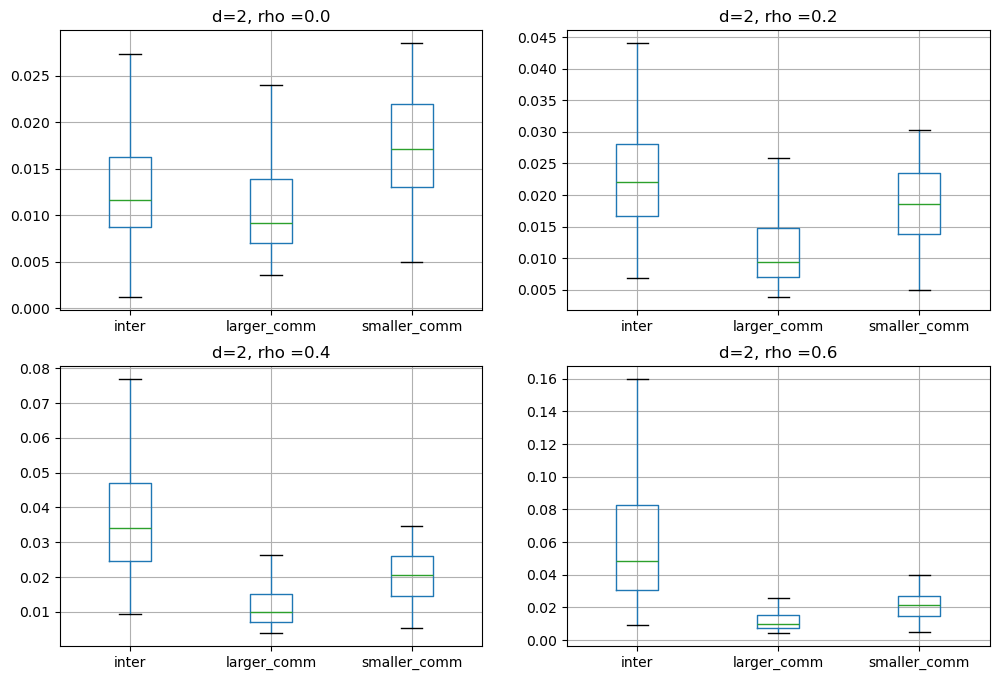

In [93]:
Rho = [0.0,0.2,0.4,0.6]
plt.figure(figsize=(12,8))

for ctr in range(len(Rho)):
    
    rho = Rho[ctr]
    G = readOverlapGraph(xi=0.15, eta=1.5, rho=rho, d=2)
    ## ignore outliers
    C = [set(x) for x in G.vs['comms']]
    Communities = mems2comms(C)[1:]
    nc = len(Communities)
    L = []
    for i in range(nc-1):
        for j in range(i+1,nc):
            I = set(Communities[i]).intersection(set(Communities[j]))
            if len(I)>=30:
                sg = G.subgraph(I)
                idt = 2*sg.ecount()/(sg.vcount()*(sg.vcount()-1))
                inter = sg.vcount()
                if len(Communities[i]) > len(Communities[j]):
                    large = i
                    small = j
                else:
                    large=j
                    small=i
                sg = G.subgraph(Communities[large])
                ldt = 2*sg.ecount()/(sg.vcount()*(sg.vcount()-1))
                sg = G.subgraph(Communities[small])
                sdt = 2*sg.ecount()/(sg.vcount()*(sg.vcount()-1))
                L.append([len(I),len(Communities[large]),len(Communities[small]),idt,ldt,sdt])
    plt.subplot(2,2,ctr+1)
    _df = pd.DataFrame(L, columns=['intersection','large','small','inter','larger_comm','smaller_comm'])
    _df.boxplot(column=['inter','larger_comm','smaller_comm'], showfliers=False)
    if ctr>1:
        plt.xlabel('')
    plt.title('d=2, rho ='+str(rho))
plt.savefig('abcdoo_rho_d2.png')

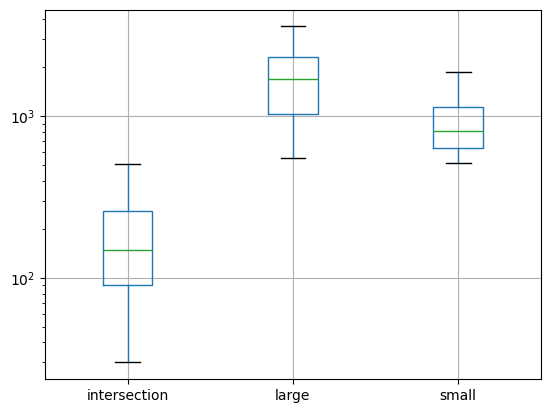

In [94]:
_df.boxplot(column=['intersection','large','small'],showfliers=False)
plt.yscale('log')
plt.savefig('abcdoo_rho_d2_sizes.png')

## Only two communities - overlap


In [99]:
## Read ABCD+oo graph
def readOverlapGraph2(xi=0.5, eta=1.5, rho=0.0, d=2):
    fn = path+'twocomms/networkfile_'+str(xi)+'_'+str(eta)+'_'+str(rho)+'_'+str(d)+'.txt'
    Edges = pd.read_csv(fn, sep='\t', header=None)-1
    G = ig.Graph.DataFrame(Edges, directed=False)
    ## read communities
    fn = path+'twocomms/communityfile_'+str(xi)+'_'+str(eta)+'_'+str(rho)+'_'+str(d)+'.txt'
    L = []
    with open(fn, "r") as infile:
        for line in infile:
            x = line.split('\t')
            L.append([int(y)-1 for y in x[1].rstrip()[1:-1].split(',')]) ## map to 0-based
    G.vs['comms'] = L
    G.vs['n_comms'] = [len(x) for x in G.vs['comms']]
    return G


In [143]:
L=[]
for d in [2,5,10]:
    for rho in [0.0,0.2,0.4,0.6]:
        G = readOverlapGraph2(xi=0.15, eta=1.2, rho=rho, d=d)
        C = [set(x) for x in G.vs['comms']]
        Communities = mems2comms(C)[1:]
        I = set(Communities[0]).intersection(set(Communities[1]))
        sg = G.subgraph(I)
        idt = 2*sg.ecount()/(sg.vcount()*(sg.vcount()-1))
        sg = G.subgraph(Communities[0])
        ldt = 2*sg.ecount()/(sg.vcount()*(sg.vcount()-1))
        sg = G.subgraph(Communities[1])
        sdt = 2*sg.ecount()/(sg.vcount()*(sg.vcount()-1))
        L.append([d,rho,idt,ldt,sdt])
df = pd.DataFrame(L,columns=['d','rho','inter','C1','C2'])
Gd = 2*G.ecount()/(G.vcount()*(G.vcount()-1))

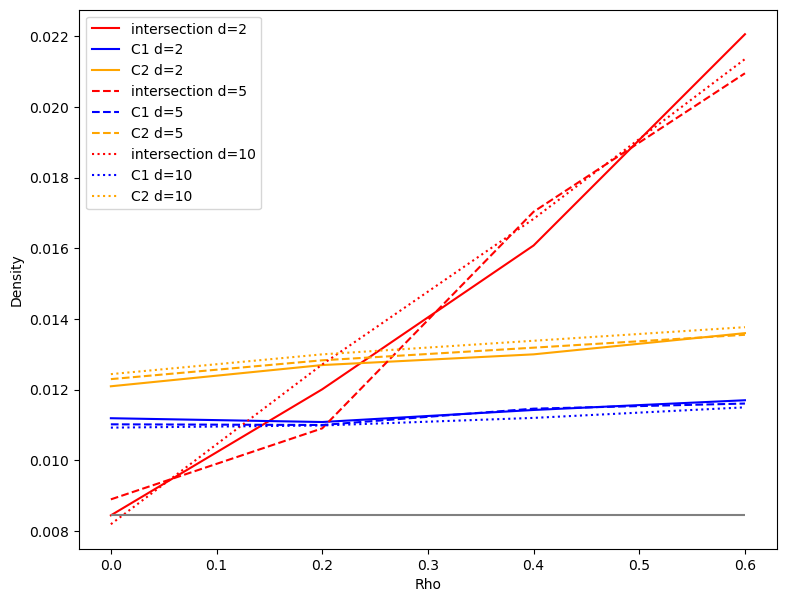

In [146]:
cls = ['red','blue','orange']
sty = ['-','--',':']
D = [2,5,10]
plt.figure(figsize=(9,7))
for ctr in range(len(D)):
    d = D[ctr]
    _df = df[df.d==d]
    plt.plot(_df.rho,_df.inter,label='intersection d='+str(d),color=cls[0],linestyle=sty[ctr])
    plt.plot(_df.rho,_df.C1,label='C1 d='+str(d),color=cls[1],linestyle=sty[ctr])
    plt.plot(_df.rho,_df.C2,label='C2 d='+str(d),color=cls[2],linestyle=sty[ctr])
    plt.legend();
plt.hlines(Gd,0,.6,color='grey')
plt.ylabel('Density')
plt.xlabel('Rho');


In [ ]:
def Jac(a,b):
    return len(set(a).intersection(set(b))) / len(set(a).union(set(b)))
## community intersections?
n = G.vcount()
d = np.array(G.degree())/sum(G.degree())
L = []
for i in range(nc-1):
    for j in range(i+1,nc):
        l1 = len(Communities[i])
        l2 = len(Communities[j])
        v1 = np.random.choice(n, l1, replace=False, p=d)
        v2 = np.random.choice(n, l2, replace=False, p=d)
        L.append([Jac(Communities[i],Communities[j]) , Jac(v1,v2)])
df  = pd.DataFrame(L, columns=['abcdoo','random'])
sns.violinplot([df.random[df.random>0],df.abcdoo[df.abcdoo>0]], log_scale=True)
plt.title('Jaccard');        

In [ ]:
epsilon=.0001
sns.violinplot([ df.random[df.abcdoo>0]+epsilon, df.abcdoo[df.abcdoo>0]+epsilon ], log_scale=True )
plt.title('Jaccard');     


In [ ]:
asfd

# WAW Figure - Values of NIEF for nodes in k communities

To compare with DBLP


In [ ]:
G = readGraph(xi=0.15, eta=2.5, rep=1)
G.vs['name'] = [str(i) for i in np.arange(G.vcount())]
## GT community membership matrix
X = np.repeat(np.arange(G.vcount(), dtype=int), G.vs['n_comms'])
Y = np.array([i for j in G.vs['comms'] for i in j])
n = len(X)
M = sparse.csr_matrix( (np.repeat(1,n), (X,Y)), shape=(G.vcount(), max(Y)+1) )
A = G.get_adjacency_sparse()
## Compute CAS measures
IEF, NIEF, C, Pv, DegPart = CAS(A, M, alpha=1)


In [ ]:
L = []
for i in range(G.vcount()):
    if G.vs[i]['n_comms'] == 3:
        L.append(np.sort(np.array(NIEF[i].todense())[0])[-5:])
df = pd.DataFrame(L, columns=[5,4,3,2,1])
df.boxplot(column=[1,2,3,4,5], showfliers=False);

In [ ]:
for x in [1,2,3,4]:
    L = []
    for i in range(G.vcount()):
        if G.vs[i]['n_comms'] == x:
            L.append(np.sort(np.array(NIEF[i].todense())[0])[-5:][::-1])
    df = pd.DataFrame(L, columns=['1','2','3','4','5'])
    plt.plot(df.mean(),'o-',label=str(x))
plt.grid()
plt.legend(title='Number of communities')
plt.xlabel('Rank', fontsize=13)
plt.ylabel('Mean NIEF', fontsize=13)
plt.title('ABCD-oo Graph', fontsize=14)
#plt.show()
#plt.savefig('abcdoo_rank.png')


## Power-law fit, community sizes

In [ ]:
import powerlaw
S = []
for eta in [1.0,1.5,2.0,2.5,3.0]:
    for rep in [1,2,3,4,5,6,7,8,9,10]:
        G = readGraph(xi=0.15, eta=eta, rep=rep)
        S.extend([x[1] for x in Counter([i for j in G.vs['comms'] for i in j]).items()])


In [ ]:
## estimates for l' (xmin) and gamma (alpha)
print(min(S),max(S))
X = powerlaw.Fit(S)
print("\ngamma:", X.power_law.alpha)
print("l':", X.power_law.xmin)
print("KS statistic:", X.power_law.D)


In [ ]:
## Starting from l'
fig1 = X.power_law.plot_ccdf(color="black", linestyle="-")
fig1 = X.plot_ccdf(ax=fig1, linewidth=2, color="gray", original_data=False, linestyle=":")
fig1.set_xlabel("size", fontsize=13)
fig1.set_ylabel("inverse cdf", fontsize=13);

## (1) AMI vs dropped nodes, ABCD-oo with eta == 1

* (1a) use different scores to rank the nodes (w.r.t. outlyingness), but final score w.r.t. Leiden partition
* (1b) actually use the scores for ranking AND scoring


In [ ]:
with open('Results/leiden_ranked.pkl','rb') as fp:
    df = pickle.load(fp)


In [ ]:
XIs = [.35,.4,.45,.5,.55,.575,.6,.625,.65]
plt.figure(figsize=(12,10))
for i in range(len(XIs)):
    xi = XIs[i]
    plt.subplot(3,3,i+1)
    D = df[df.xi==XIs[i]]
    D = D.groupby(by=['dropped','algo'])['ami'].mean()
    plt.plot(D.loc[:,'IEF'].index, D.loc[:,'IEF'], label='IEF')
    plt.plot(D.loc[:,'beta'].index, D.loc[:,'beta'], label='Beta')
    plt.plot(D.loc[:,'C'].index, D.loc[:,'C'], label='C')
    plt.plot(D.loc[:,'P'].index, D.loc[:,'P'], label='p-value')
    if i==0:
        plt.legend()
    if i>5:
        plt.xlabel('Dropped nodes')
    if i%3==0:
        plt.ylabel('AMI');
    plt.title(r'$\xi$ ='+str(xi))
#plt.savefig('AMI_leiden.png');


In [ ]:
with open('Results/cas_ranked.pkl','rb') as fp:
    df = pickle.load(fp)


In [ ]:
plt.figure(figsize=(12,10))
for i in range(len(XIs)):
    xi = XIs[i]
    plt.subplot(3,3,i+1)
    D = df[df.xi==XIs[i]]
    D = D.groupby(by=['dropped','algo'])['ami'].mean()
    plt.plot(D.loc[:,'IEF'].index, D.loc[:,'IEF'], label='IEF')
    plt.plot(D.loc[:,'beta'].index, D.loc[:,'beta'], label='Beta')
    plt.plot(D.loc[:,'C'].index, D.loc[:,'C'], label='C')
    plt.plot(D.loc[:,'P'].index, D.loc[:,'P'], label='p-value')
    if i==0:
        plt.legend()
    if i>5:
        plt.xlabel('Dropped nodes')
    if i%3==0:
        plt.ylabel('AMI');
    plt.title(r'$\xi$ ='+str(xi))
#plt.savefig('AMI_scores.png');


## (2) TP vs FP, varying threshold

In [ ]:
%%time
ETA = 1.0
range_IEF = np.arange(.05,.501,.025)
range_beta = np.arange(.05,.501,.025)
range_C = np.arange(1,8.001,.25)
range_P = np.arange(.90,1,.0025)
XIs = [.35,.65]
REP = 1
L = []

for xi in XIs:
    g = readGraph(xi=xi, eta=ETA, rep=1)
    g.vs['leiden'] = g.community_leiden(objective_function='modularity').membership
    g.vs['gt'] = [x[0] for x in g.vs['comms']] ## pick the first; 0 == outlier
    A = g.get_adjacency_sparse()
    IEF, Beta, C, P, DegPart = CAS(A, partition2sparse(g.vs['leiden']))
#     for th in range_IEF:
#         M = score_to_memberships(IEF, DegPart, th)
#         L.append(['IEF', xi, th, Counter(np.array(M.sum(axis=1)).flatten())[0], sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(g.vs['gt']) == 0))])
    for th in range_beta:
        M = score_to_memberships(Beta, DegPart, th)
        L.append(['Beta', xi, th, Counter(np.array(M.sum(axis=1)).flatten())[0], sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(g.vs['gt']) == 0))])
#     for th in range_C:
#         M = score_to_memberships(C, DegPart, th)
#         L.append(['C', xi, th, Counter(np.array(M.sum(axis=1)).flatten())[0], sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(g.vs['gt']) == 0))])
#     for th in range_P:
#         M = score_to_memberships(P, DegPart, th)
#         L.append(['P', xi, th, Counter(np.array(M.sum(axis=1)).flatten())[0], sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(g.vs['gt']) == 0))])

df = pd.DataFrame(L, columns=['score','xi','threshold','outliers','TP'])
df['FP'] = df['outliers'] - df['TP']


In [ ]:
_df = df[df.score == 'Beta']

plt.figure(figsize=(12,10))

for i in range(len(XIs)):
    xi = XIs[i]
    D = _df[_df.xi == xi]
    plt.subplot(3,3,i+1)
    plt.plot(D.threshold, D.TP, label='True Positives')
    plt.plot(D.threshold, D.FP, label='False Positives')
    plt.hlines(y=num_out, xmin=min(D.threshold), xmax=max(D.threshold), linestyles='dotted', color='grey')
    plt.ylim((-10,1000))
    if i==0:
        plt.legend()
    if i>5:
        plt.xlabel('threshold')
    if i%3==0:
        plt.ylabel('Count');
    plt.title(r'Outliers with $\xi$ ='+str(xi)) 
#plt.savefig('abcdoo_TP_FP_Beta_eta_3_0.png');    


## More tests - as with DBLP


In [ ]:
XI = 0.35
ETA = 1.5
REP = 1

G = readGraph(xi=XI, eta=ETA, rep=REP)
G.vs['leiden'] = G.community_leiden(objective_function='modularity').membership
G.vs['gt'] = [x[0] for x in G.vs['comms']] ## pick the first; 0 == outlier
## Add community degrees to G (deg_A(v)'s)
for v in G.vs:
    ctr = Counter([i for x in v.neighbors() for i in x['comms']])
    v['degrees'] = [ctr[i] if i in ctr.keys() else 0 for i in v['comms'] ]

A = G.get_adjacency_sparse()
IEF, Beta, C, Pv, DegPart = CAS(A, partition2sparse(G.vs['leiden']), alpha=1)

In [ ]:
## Thresholds below are somewhat arbitrary

M = score_to_memberships(IEF, DegPart, threshold=.2)
outliers = np.where(np.array(M.sum(axis=1).flatten().tolist()[0])==0)[0]
print('IEF:')
print('outliers found:',len(outliers))
print('ground-truth outliers found:',sum([G.vs[i]['gt']==0 for i in outliers]))

M = score_to_memberships(Beta, DegPart, threshold=.2)
outliers = np.where(np.array(M.sum(axis=1).flatten().tolist()[0])==0)[0]
print('\nBeta score:')
print('outliers found:',len(outliers))
print('ground-truth outliers found:',sum([G.vs[i]['gt']==0 for i in outliers]))

M = score_to_memberships(C, DegPart, threshold=3)
outliers = np.where(np.array(M.sum(axis=1).flatten().tolist()[0])==0)[0]
print('\nC score:')
print('outliers found:',len(outliers))
print('ground-truth outliers found:',sum([G.vs[i]['gt']==0 for i in outliers]))

M = score_to_memberships(Pv, DegPart, threshold=.95)
outliers = np.where(np.array(M.sum(axis=1).flatten().tolist()[0])==0)[0]
print('\np-value score:')
print('outliers found:',len(outliers))
print('ground-truth outliers found:',sum([G.vs[i]['gt']==0 for i in outliers]))


## (3) Distributions - true communities vs all non-zeros

Nodes in 3 communities

* Input: membership (sparse) matrix M and (Sparse) adjacency A


In [ ]:
%%time
plt.style.use('default')
K = 3
for xi in [0.5]:
    for eta in [3.0]:
        G = readGraph(xi=xi, eta=eta, rep=1)
        G.vs['leiden'] = G.community_leiden(objective_function='modularity').membership
        G.vs['gt'] = [x[0] for x in G.vs['comms']] ## pick the first; 0 == outlier

        ## Add community degrees to G (deg_A(v)'s)
        for v in G.vs:
            ctr = Counter([i for x in v.neighbors() for i in x['comms']])
            v['degrees'] = [ctr[i] if i in ctr.keys() else 0 for i in v['comms'] ]

        ## GT community membership matrix
        X = np.repeat(np.arange(G.vcount(), dtype=int), G.vs['n_comms'])
        Y = np.array([i for j in G.vs['comms'] for i in j])
        n = len(X)
        M = sparse.csr_matrix( (np.repeat(1,n), (X,Y)), shape=(G.vcount(), max(Y)+1) )
        A = G.get_adjacency_sparse()

        ## Compute CAS measures
        IEF, Beta, C, Pv, DegPart = CAS(A, M, alpha=1)
        
        ## compute average 
        V = np.array(G.vs['n_comms']) == K
        GT = np.array([G.vs[v]['comms'] for v in np.where(V)])[0] 
        Degs = np.array([G.vs[v]['degrees'] for v in np.where(V)])[0]        

        plt.figure(figsize=(12,10))
        ## IEF
        X = IEF[V]
        L = []
        for i in range(GT.shape[0]):
            x = np.argsort(X[i].toarray()[0])[::-1]
            L.append([np.where(x==GT[i][j])[0][0] for j in range(K) ])
        df = pd.DataFrame(np.array(L)+1)
        my_dict = {}
        for j in [1,2,3,4,5,6,7,8]:
            _df = df[np.min(Degs, axis=1) >= j]
            x = _df.mean(axis=1)
            my_dict[str(j)] = list(x)
        plt.subplot(221)
        plt.hlines((K+1)/2,0,7,linestyles='dotted')
        ax = sns.boxplot([x for x in my_dict.values()], showfliers=False, );
        ax.set_xticks(np.arange(8))
        ax.grid(linestyle=':')
        ax.set_xticklabels(my_dict.keys())
        plt.ylabel('average rank for '+str(K)+' communities', fontsize=12);
        plt.title('IEF', fontsize=14);

        ## Beta
        X = Beta[V]
        L = []
        for i in range(GT.shape[0]):
            x = np.argsort(X[i].toarray()[0])[::-1]
            L.append([np.where(x==GT[i][j])[0][0] for j in range(K) ])
        df = pd.DataFrame(np.array(L)+1)
        my_dict = {}
        for j in [1,2,3,4,5,6,7,8]:
            _df = df[np.min(Degs, axis=1) >= j]
            x = _df.mean(axis=1)
            my_dict[str(j)] = list(x)
        plt.subplot(222)
        plt.hlines((K+1)/2,0,7,linestyles='dotted')
        ax = sns.boxplot([x for x in my_dict.values()], showfliers=False, );
        ax.set_xticks(np.arange(8))
        ax.grid(linestyle=':')
        ax.set_xticklabels(my_dict.keys())
        #plt.xlabel('min community degree at least');
        #plt.ylabel('average rank for '+str(K)+' communities');
        plt.title('Beta', fontsize=14);

        ## C
        X = C[V]
        L = []
        for i in range(GT.shape[0]):
            x = np.argsort(X[i].toarray()[0])[::-1]
            L.append([np.where(x==GT[i][j])[0][0] for j in range(K) ])
        df = pd.DataFrame(np.array(L)+1)
        my_dict = {}
        for j in [1,2,3,4,5,6,7,8]:
            _df = df[np.min(Degs, axis=1) >= j]
            x = _df.mean(axis=1)
            my_dict[str(j)] = list(x)
        plt.subplot(223)
        plt.hlines((K+1)/2,0,7,linestyles='dotted')
        ax = sns.boxplot([x for x in my_dict.values()], showfliers=False, );
        ax.set_xticks(np.arange(8))
        ax.grid(linestyle=':')
        ax.set_xticklabels(my_dict.keys())
        plt.xlabel('Minimum in-community degree', fontsize=12);
        plt.ylabel('average rank for '+str(K)+' communities', fontsize=12);
        plt.title('C', fontsize=14);

        ## Pv
        X = Pv[V]
        L = []
        for i in range(GT.shape[0]):
            x = np.argsort(X[i].toarray()[0])[::-1]
            L.append([np.where(x==GT[i][j])[0][0] for j in range(K) ])
        df = pd.DataFrame(np.array(L)+1)
        my_dict = {}
        for j in [1,2,3,4,5,6,7,8]:
            _df = df[np.min(Degs, axis=1) >= j]
            x = _df.mean(axis=1)
            my_dict[str(j)] = list(x)
        plt.subplot(224)
        plt.hlines((K+1)/2,0,7,linestyles='dotted')
        ax = sns.boxplot([x for x in my_dict.values()], showfliers=False, );
        ax.set_xticks(np.arange(8))
        ax.grid(linestyle=':')
        ax.set_xticklabels(my_dict.keys())
        plt.xlabel('Minimum in-community degree', fontsize=12);
        #plt.ylabel('average rank for '+str(K)+' communities');
        plt.title('p-values', fontsize=14);

        ## save PNG
        fn = 'abcdoo_'+str(xi)+'_'+str(eta)+'_'+str(K)+'.png'
        #plt.savefig(fn)


In [ ]:
score = []
gt = []
nc = []
for ctr in np.arange(1,MAX+1):
    V = np.array(G.vs['n_comms']) == ctr
    for i in range(len(V)):
        if V[i]:
            x = IEF[i].toarray()[0]
            y = np.array(G.vs[i]['comms'])
            score.extend([x[i] for i in y])
            gt.extend(np.repeat(True,len(y)))
            score.extend(x[x>0])
            gt.extend(np.repeat(False,sum(x>0)))
            nc.extend(np.repeat(ctr,len(y)+sum(x>0)))
D = pd.DataFrame( np.array([score,gt,nc]).transpose(), columns=['IEF','gt','number of communities'])
D['number of communities'] = [int(x) for x in D['number of communities']]
g = sns.boxplot(x='number of communities', y='IEF', hue='gt', data=D, 
                showfliers=False, legend='full')
leg = g.axes.get_legend()
leg.set_title('IEF scores')
new_labels = ['all non-zero','ground-truth only']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
# fn = 'abcdoo_ied_0.5_3.0.png'
# plt.savefig(fn);


In [ ]:
score = []
gt = []
nc = []
for ctr in np.arange(1,MAX+1):
    V = np.array(G.vs['n_comms']) == ctr
    for i in range(len(V)):
        if V[i]:
            x = Beta[i].toarray()[0]
            y = np.array(G.vs[i]['comms'])
            score.extend([x[i] for i in y])
            gt.extend(np.repeat(True,len(y)))
            score.extend(x[x>0])
            gt.extend(np.repeat(False,sum(x>0)))
            nc.extend(np.repeat(ctr,len(y)+sum(x>0)))
D = pd.DataFrame( np.array([score,gt,nc]).transpose(), columns=['Beta','gt','number of communities'])
D['number of communities'] = [int(x) for x in D['number of communities']]
g = sns.boxplot(x='number of communities', y='Beta', hue='gt', data=D, 
                showfliers=False, legend='full')
leg = g.axes.get_legend()
leg.set_title('Beta scores')
new_labels = ['all non-zero','ground-truth only']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
# fn = 'abcdoo_beta_0.5_3.0.png'
# plt.savefig(fn);


In [ ]:
score = []
gt = []
nc = []
for ctr in np.arange(1,MAX+1):
    V = np.array(G.vs['n_comms']) == ctr
    for i in range(len(V)):
        if V[i]:
            x = C[i].toarray()[0]
            y = np.array(G.vs[i]['comms'])
            score.extend([x[i] for i in y])
            gt.extend(np.repeat(True,len(y)))
            score.extend(x[x>0])
            gt.extend(np.repeat(False,sum(x>0)))
            nc.extend(np.repeat(ctr,len(y)+sum(x>0)))
D = pd.DataFrame( np.array([score,gt,nc]).transpose(), columns=['C','gt','number of communities'])
D['number of communities'] = [int(x) for x in D['number of communities']]
g = sns.boxplot(x='number of communities', y='C', hue='gt', data=D, 
                showfliers=False, legend='full')
leg = g.axes.get_legend()
leg.set_title('C scores')
new_labels = ['all non-zero','ground-truth only']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
# fn = 'abcdoo_c_0.5_3.0.png'
# plt.savefig(fn);


In [ ]:
score = []
gt = []
nc = []
for ctr in np.arange(1,MAX+1):
    V = np.array(G.vs['n_comms']) == ctr
    for i in range(len(V)):
        if V[i]:
            x = Pv[i].toarray()[0]
            y = np.array(G.vs[i]['comms'])
            score.extend([x[i] for i in y])
            gt.extend(np.repeat(True,len(y)))
            score.extend(x[x>0])
            gt.extend(np.repeat(False,sum(x>0)))
            nc.extend(np.repeat(ctr,len(y)+sum(x>0)))
D = pd.DataFrame( np.array([score,gt,nc]).transpose(), columns=['P','gt','number of communities'])
D['number of communities'] = [int(x) for x in D['number of communities']]
g = sns.boxplot(x='number of communities', y='P', hue='gt', data=D, 
                showfliers=False, legend='full')
leg = g.axes.get_legend()
leg.set_title('P scores')
new_labels = ['all non-zero','ground-truth only']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
plt.ylim(.5,1);
# fn = 'abcdoo_p_0.5_3.0.png'
# plt.savefig(fn);


# Extras

## Testing Rising Tide Stuff

In [ ]:
G = readGraph(xi=0.4, eta=1.5, rep=1)
A = G.get_adjacency_sparse()
M = partition2sparse(G.community_leiden(objective_function='modularity').membership)
IEF, Beta, C, Pv, DegPart = CAS(A,M)
Counter(np.array(M.sum(axis=1)).flatten())


In [ ]:
B = score_to_memberships(Beta, DegPart, threshold=.2, min_deg_in=2)
Counter(np.array(B.sum(axis=1)).flatten())


In [ ]:
Counter(G.vs['n_comms'] == np.array(B.sum(axis=1)).flatten())

In [ ]:
RT = rising_tide(A, Beta, min_deg_in=2)
Counter(np.array(RT.sum(axis=1)).flatten())


In [ ]:
Counter(G.vs['n_comms'] == np.array(RT.sum(axis=1)).flatten())

In [ ]:
Counter(np.array(RT.sum(axis=1)).flatten())


In [ ]:
G.vs['gt'] = [x[0] for x in G.vs['comms']]

In [ ]:
AMI(G.vs['gt'], G.community_leiden(objective_function='modularity').membership)

In [ ]:
AMI(G.vs['gt'], np.array(Beta.argmax(axis=1)).flatten())

In [ ]:
AMI(G.vs['gt'], np.array(RT.argmax(axis=1)).flatten())

## Testing edges

In [ ]:
G = readGraph(xi=0.4, eta=1.5, rep=1)
## GT community membership matrix
X = np.repeat(np.arange(G.vcount(), dtype=int), G.vs['n_comms'])
Y = np.array([i for j in G.vs['comms'] for i in j])
n = len(X)
M = sparse.csr_matrix( (np.repeat(1,n), (X,Y)), shape=(G.vcount(), max(Y)+1) )
A = G.get_adjacency_sparse()

## Compute CAS measures
IEF, Beta, C, Pv, DegPart = CAS(A, M, alpha=1)


In [ ]:
## Add community degrees to G (deg_A(v)'s)
for v in G.vs:
    ctr = Counter([i for x in v.neighbors() for i in x['comms']])
    v['degrees'] = [ctr[i] if i in ctr.keys() else 0 for i in v['comms'] ]
## set outliers to 0
b = np.where(np.array([x[0]==0 for x in G.vs['comms']]))[0]
for i in b:
    G.vs[i]['n_comms'] = 0
    

In [ ]:
Score = []
Inter = []
for e in G.es:
    Score.append(np.max(np.minimum(np.array(Beta[e.source].todense())[0], np.array(Beta[e.target].todense())[0])))
    Inter.append(len(set(G.vs[e.source]['comms']).intersection(set(G.vs[e.target]['comms']))))


In [ ]:
df = pd.DataFrame()
df['Score'] = Score
df['Intersection'] = Inter
sns.boxplot(y='Score', x='Intersection', data=df)
plt.grid();


In [ ]:
## Leiden
M = partition2sparse(G.community_leiden(objective_function='modularity').membership)
IEF, Beta, C, Pv, DegPart = CAS(A,M)


In [ ]:
Score = []
Inter = []
for e in G.es:
    Score.append(np.max(np.minimum(np.array(Beta[e.source].todense())[0], np.array(Beta[e.target].todense())[0])))
    Inter.append(len(set(G.vs[e.source]['comms']).intersection(set(G.vs[e.target]['comms']))))


In [ ]:
df = pd.DataFrame()
df['Score'] = Score
df['Intersection'] = Inter
sns.boxplot(y='Score', x='Intersection', data=df)
plt.grid();


In [ ]:
## drop edges
E = np.where(np.array(Score)<.1)[0]
G.delete_edges(E)

In [ ]:
G.vs['gt'] = [x[0] for x in G.vs['comms']]

In [ ]:
AMI(G.vs['gt'], G.community_leiden(objective_function='modularity').membership)

In [ ]:
Counter(G.vs['n_comms'])

In [ ]:
Counter(Inter)

## Computing oNMI over a range of threshold values
* This is starting from Leiden, drop it
